<a href="https://colab.research.google.com/github/shivendr7/SatGAN/blob/master/EEGAN_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

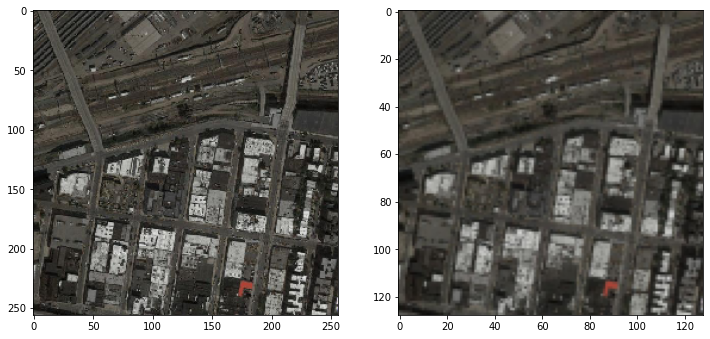

In [75]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))

In [76]:
resized_list=(resized_list-127.5)/127.5
src_list=(src_list-127.5)/127.5

In [77]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Concatenate, Lambda, Subtract, Add, Activation, Reshape, Multiply, Flatten, Dropout, Dense, BatchNormalization, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import RandomNormal, Ones
import tensorflow as tf
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import keras.backend as K
import numpy as np

In [78]:
def dense_block(in_layer):
  init=RandomNormal(stddev=0.2)
  conv1=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(in_layer)
  conv11=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv12=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv13=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  concat1=Concatenate()([conv11, conv12, conv13])
  conv201=Concatenate()([concat1, conv11])
  conv202=Concatenate()([concat1, conv12])
  conv203=Concatenate()([concat1, conv13])
  conv21i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv201)
  conv22i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv202)
  conv23i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv203)
  conv21=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv21i)
  conv22=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv22i)
  conv23=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv23i)
  concat2=Concatenate()([conv21, conv22, conv23])
  conv301=Concatenate()([concat2, conv21i])
  conv302=Concatenate()([concat2, conv22i])
  conv303=Concatenate()([concat2, conv23i])
  conv31i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv301)
  conv32i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv302)
  conv33i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv303)
  conv31=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv31i)
  conv32=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv32i)
  conv33=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv33i)
  concat3=Concatenate()([conv31, conv32, conv33])
  conv401=Concatenate()([concat3, conv31i])
  conv402=Concatenate()([concat3, conv32i])
  conv403=Concatenate()([concat3, conv33i])
  conv41i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv401)
  conv42i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv402)
  conv43i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv403)
  concat4=Concatenate()([conv41i, conv42i, conv43i])
  out_layer=Concatenate()([concat4, conv1])
  return out_layer

In [79]:
inp=Input(shape=(28,28,1))
m=Model(inputs=inp, outputs=dense_block(inp))
#plot_model(m)

In [80]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [81]:
def build_udsn(image_shape):
  inp=Input(shape=image_shape)
  db1=dense_block(inp)
  con=Concatenate()([db1, db1])
  db2=dense_block(con)
  con=Concatenate()([db1, db2, db2])
  db3=dense_block(con)
  con=Concatenate()([db1, db2, db3, db3])
  db4=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db4])
  db5=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db5, db5])
  db6=dense_block(con)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(db6)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  LR=Conv2D(filters=12, kernel_size=(3,3), padding='same')(sub_net)
  LR=LeakyReLU(alpha=0.02)(LR)
  Ibase=SubpixelConv2D(LR.shape, scale=2)(LR)
  Ibase=BatchNormalization(momentum=0.8)(Ibase)
  Ibase=Activation('tanh')(Ibase)
  model=Model(inputs=inp, outputs=Ibase)
  return model

In [82]:
#eesn essentials
def meanfilter(shape, dtype=None):   #kernel to find mean of 3-channel pixel data
  f=np.array([
              [[[.3333],
                [.3333],
                [.33333]]]
  ])
  return K.variable(f, dtype='float32')
def laplacian(shape, dtype=None):   #laplacian kernel
  f=np.array([
      [[[-1]],[[-1]],[[-1]]],
      [[[-1]],[[ 8]],[[-1]]],
      [[[-1]],[[-1]],[[-1]]]
  ])
  return K.variable(f, dtype='float32')
def channel_thrice(shape, dtype=None):   #kernel to triplicate the single channel data
  f=np.array([
              [[[1, 1, 1]]]   #3 for three layers of filters
  ])
  return K.variable(f, dtype='float32')

In [83]:
def build_eesn(Ibase_shape):
  inp=Input(shape=(Ibase_shape))
  bw=Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer=meanfilter, trainable=False)(inp)  #no change recommended   
  Iedge=Conv2D(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=laplacian, trainable=False)(bw)     #no change recommended
  Itrip=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Iedge)   #no change recommended
  
  sub=Subtract()([inp, Itrip])
  ee=Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))(Iedge)
  ee=Conv2D(filters=64, kernel_size=(3,3), padding='same')(ee)
  ee=Conv2D(filters=16, kernel_size=(1,1), padding='same')(ee)
  
  #dense net
  db=dense_block(ee)
  db=dense_block(db)
  db=dense_block(db)
  db=Conv2D(16, kernel_size=(3,3), padding='same')(db)

  #mask branch
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(ee)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=32, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Activation('sigmoid')(mb)

  #transpose=Permute((2,1,3), input_shape=db.shape)(db)
  product=Multiply()([db, mb])  #multiplies element wise
  #con=Concatenate()([mb, db])
  #transpose2=Permute((2,1,3), input_shape=product.shape)(product)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(product)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  ee=Conv2D(4, kernel_size=(3,3), padding='same')(sub_net)
  Istedge=SubpixelConv2D(ee.shape, scale=2)(ee)
  #Istedge=Conv2D(1, kernel_size=(3,3), padding='same')(Istedge)
  Istedge=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Istedge)  #no change recommended
  
  #Istedge=BatchNormalization()(Istedge)
  SR=Add()([Istedge, sub])
  SR=BatchNormalization()(SR)
  SR=Activation('tanh')(SR)
  
  model=Model(inputs=inp, outputs=SR)
  return model

In [84]:
def consistency_loss(y_true, y_pred):
  lambd=5
  return charbonnier_penalty(y_true, y_pred)

mape=MeanAbsolutePercentageError()
def consistency_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt)
  return model

In [85]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)

In [86]:
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.0002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

In [87]:
def build_discriminator(img_shape):
  def block(Input, k, n, s):
    l1=Conv2D(n, kernel_size=(k,k), strides=(s,s), padding='same')(Input)
    Bn=BatchNormalization()(l1)
    Lrlu=LeakyReLU(alpha=0.02)(Bn)
    return Lrlu
  I1=Input(shape=img_shape)
  c1=Conv2D(64, kernel_size=(3,3), padding='same')(I1)
  l1=LeakyReLU(alpha=0.02)(c1)
  b1=block(l1, 3, 64, 2)
  b2=block(b1, 3, 128, 1)
  b3=block(b2, 3, 128,2)
  b4=block(b3, 3, 256, 1)
  b5=block(b4, 3, 256, 2)
  b6=block(b5, 3, 512, 1)
  b7=block(b6, 3, 512, 2)
  b8=Flatten()(b7)
  b9=Dropout(.5)(b8)
  l8=Dense(1024)(b9)
  b10=Dropout(.25)(l8)
  l9=LeakyReLU(alpha=0.02)(b10)
  l10=Dense(1, activation='sigmoid')(l9)
  m=Model(inputs=I1, outputs=l10)
  opt=Adam(learning_rate=0.00002, beta_1=0.5, clipnorm=1)
  m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return m

In [88]:
def build_gan(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  out=disc(ISR)
  disc.trainable=False
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.00002, beta_1=0.1, clipnorm=1)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [89]:
udsn=build_udsn(image_shape=(128,128,3))
#plot_model(udsn)

In [90]:
eesn=build_eesn(Ibase_shape=(256,256,3))
#plot_model(eesn)

In [91]:
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()

In [92]:
cons_model=consistency_model(img_shape=(128,128,3))
#cons_model.summary()

In [93]:
disc=build_discriminator(img_shape=(256,256,3))
#disc.summary()

In [94]:
gan=build_gan(img_shape=(128,128,3))
#gan.summary()

In [95]:
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc

In [96]:
def train_consistency_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]

  loss, acc=cons_model.train_on_batch(input_batch, HR_batch), 0
  return loss, acc

In [97]:
def generate_real_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  HR_batch=src_list[ix]
  y_real=np.ones(shape=(n_batch,))
  return HR_batch, y_real

def generate_fake_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  LR_batch=resized_list[ix]
  HR_batch_fake=eesn(udsn(LR_batch))
  y_fake=np.zeros(shape=(n_batch,))
  return HR_batch_fake, y_fake

In [98]:
def train(n_epochs=20, n_batch=2):
  half_batch=n_batch//2
  for i in range(n_epochs):
    ix=np.random.randint(0, 1096, n_batch)
    LR_batch=resized_list[ix]
    HR_batch=src_list[ix]
    
    #charb_loss, cons_loss=0, 0
    charb_loss, charb_acc=train_charbonnier_model(half_batch)
    cons_loss, cons_acc=train_consistency_model(half_batch)

    real_batch, y_real=generate_real_samples(half_batch)
    fake_batch, y_fake=generate_fake_samples(half_batch)

    disc_loss_real, disc_acc_real=disc.train_on_batch(real_batch, y_real)
    disc_loss_fake, disc_acc_fake=disc.train_on_batch(fake_batch, y_fake)

    false_negatives=np.ones(shape=(n_batch,))
    gan_loss, gan_acc= gan.train_on_batch(LR_batch, false_negatives)

    print('%d charb_loss[%.6f] cons_loss[%.6f] disc_loss_real[%.6f] disc_loss_fake[%.6f] gan_loss[%.6f]'%(i+1, charb_loss, cons_loss, disc_loss_real, 
                                                                                                          disc_loss_fake, gan_loss))

In [111]:
train(1000, 2)

1 charb_loss[44.563652] cons_loss[0.280150] disc_loss_real[0.000211] disc_loss_fake[0.000000] gan_loss[0.010279]
2 charb_loss[66.923508] cons_loss[0.363772] disc_loss_real[0.000001] disc_loss_fake[0.000000] gan_loss[0.513918]
3 charb_loss[67.034416] cons_loss[0.400668] disc_loss_real[0.000000] disc_loss_fake[0.000000] gan_loss[0.055677]
4 charb_loss[50.059212] cons_loss[0.328136] disc_loss_real[0.000000] disc_loss_fake[0.000000] gan_loss[0.161859]
5 charb_loss[37.815369] cons_loss[0.222080] disc_loss_real[0.000000] disc_loss_fake[0.000000] gan_loss[0.004647]
6 charb_loss[62.508633] cons_loss[0.295178] disc_loss_real[0.000000] disc_loss_fake[0.000000] gan_loss[0.002646]
7 charb_loss[27.872650] cons_loss[0.341934] disc_loss_real[0.000000] disc_loss_fake[0.000000] gan_loss[0.004885]
8 charb_loss[52.258904] cons_loss[0.384349] disc_loss_real[0.000000] disc_loss_fake[0.000000] gan_loss[0.000000]
9 charb_loss[65.564812] cons_loss[0.535424] disc_loss_real[0.000000] disc_loss_fake[0.000077] ga

In [100]:
#for i in range(1000):
#  print(i, train_charbonnier_model(1), train_consistency_model(1))

In [101]:
"""
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)
"""

"\nfrom keras.applications.vgg16 import VGG16\nvgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)\nvgg.trainable=False\n#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)\n"

In [102]:
"""
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model
"""

"\ndef charbonnier_penalty(y_true, y_pred):\n  epsilon=0.001 #compensation parameter\n  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)\n  #return K.mean(K.square(y_true- y_pred) + epsilon**2)\n\ndef charbonnier_model(img_shape):\n  inp=Input(shape=img_shape)\n  Ibase=udsn(inp)\n  #resize_Ibase=resize_layer(Ibase)\n  out=vgg(Ibase*127.5+127.5)\n  model=Model(inputs=inp, outputs=out)\n  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)\n  model.compile(loss='mse', optimizer=opt)\n  return model\n"

In [103]:
"""
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()
"""

'\ncharb=charbonnier_model(img_shape=(128,128,3))\n#charb.summary()\n'

In [104]:
"""
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc
"""

'\ndef train_charbonnier_model(n_batch):\n  ix=np.random.randint(0, 1096, n_batch)\n  input_batch=resized_list[ix]\n  HR_batch=src_list[ix]\n  #input_batch=input_batch*127.5+127.5\n  HR_batch=HR_batch*127.5+127.5\n  #extracting HR Image features through VGG\n  #HR_resized=resize_layer(HR_batch)\n  ground_feat=vgg(HR_batch)\n\n  #print(input_batch.shape)\n  \n  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0\n  return loss, acc\n'

In [105]:
"""
for i in range(100):
  print(train_charbonnier_model(1))
"""

'\nfor i in range(100):\n  print(train_charbonnier_model(1))\n'

Text(0.5, 1.0, 'IHR')

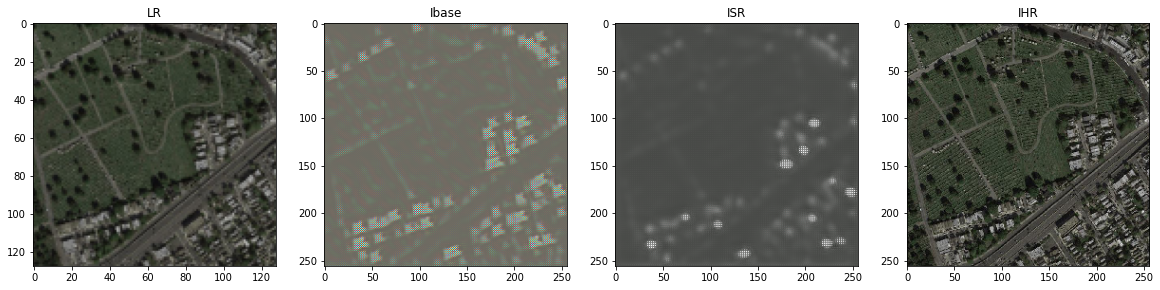

In [112]:
ix=np.random.randint(0, 1096, 1)
ILR=resized_list[ix]
IHR=src_list[ix]
Ibase=udsn(ILR)
ISR=eesn(Ibase)

plt.figure(figsize=(20, 80))

plt.subplot(1,4,1)
ILR=ILR*127.5+127.5
plt.imshow(ILR.reshape(128,128,3).astype('uint8'))
plt.title('LR')

plt.subplot(1,4,2)
Ibase1=Ibase*127.5+127.5
plt.imshow(np.array(Ibase1).reshape(256,256,3).astype('uint8'))
plt.title('Ibase')

plt.subplot(1,4,3)
ISR1=ISR*127.5+127.5
plt.imshow(np.array(ISR1).reshape(256,256,3).astype('uint8'))
plt.title('ISR')

plt.subplot(1,4,4)
plt.imshow((IHR*127.5+127.5).reshape(256,256,3).astype('uint8'))
plt.title('IHR')

In [106]:
#vgg(Ibase)

In [107]:
Ibase*127.5+127.5

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[154.59799 , 100.69473 ,  66.06183 ],
         [ 65.6408  ,  50.879463,  66.85768 ],
         [150.06822 ,  82.265366,  64.81256 ],
         ...,
         [ 64.01777 , 162.70206 ,  65.623886],
         [ 68.20494 ,  44.26599 ,  66.934265],
         [ 66.588104, 114.16246 ,  66.957886]],

        [[ 68.74361 , 141.85854 , 209.70181 ],
         [107.06669 ,  69.03324 ,  63.659702],
         [ 73.54778 , 170.19806 , 242.05978 ],
         ...,
         [ 66.9343  ,  42.826584,  64.90158 ],
         [108.742134,  50.17942 , 160.64145 ],
         [ 66.978516,  43.276573,  65.86501 ]],

        [[210.65482 , 212.48567 ,  66.87276 ],
         [ 63.188995,  43.445686, 131.15073 ],
         [224.05836 , 220.15811 ,  65.31781 ],
         ...,
         [ 63.15294 , 189.50623 , 157.7649  ],
         [ 75.46828 ,  72.229935,  69.61397 ],
         [ 66.54535 , 158.02472 , 195.11432 ]],

        ...,

        [[ 69.013374,  47.942604, 

In [108]:
ISR1

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[73.39719 , 73.09502 , 72.67797 ],
         [70.681   , 70.444885, 70.10225 ],
         [74.65506 , 74.32795 , 73.93736 ],
         ...,
         [70.35878 , 70.290276, 69.78126 ],
         [71.4936  , 71.24172 , 70.90953 ],
         [70.52362 , 70.379654, 69.94394 ]],

        [[77.819244, 77.70217 , 77.44714 ],
         [70.37625 , 70.10675 , 69.732544],
         [83.91173 , 83.82449 , 83.588005],
         ...,
         [70.04572 , 69.797585, 69.46352 ],
         [71.1803  , 70.87807 , 70.6756  ],
         [69.876595, 69.629524, 69.296104]],

        [[71.96253 , 71.74777 , 71.16533 ],
         [68.56047 , 68.322815, 68.082855],
         [70.78902 , 70.56862 , 69.97427 ],
         ...,
         [70.45586 , 70.42798 , 70.01503 ],
         [71.49171 , 71.270546, 70.90083 ],
         [70.24812 , 70.16917 , 69.85741 ]],

        ...,

        [[70.8743  , 70.62836 , 70.29023 ],
         [70.49666 , 70.22472 , 69.891495],


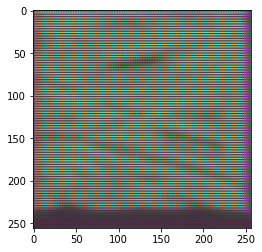

In [109]:
plt.imshow(np.array(Ibase*127.5+127.5).reshape(256,256,3).astype('uint8'))

In [110]:
Ibase.shape

TensorShape([1, 256, 256, 3])